In [1]:
import json
import numpy as np
import pandas as pd
import os
import h5py
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
X = []
y = []
with h5py.File("behaviours.hdf5", 'r') as ds:
    for i, key in enumerate(ds):
        print("Loading", key)
        X.append(ds[key][...])
        y.append(np.ones(ds[key].shape[0])*i)
        
        
X = np.concatenate(X, axis=0)
X[np.isnan(X)] = 0
y = np.concatenate(y, axis=0)

print(X.shape, y.shape)


#0         "/roboy/middleware/MotorStatus/displacement/3",
#1         "/roboy/middleware/MotorStatus/displacement/5",
#2         "/roboy/middleware/MotorStatus/displacement/6",
#3         "/roboy/middleware/MotorStatus/displacement/10",
#4         "/roboy/middleware/MotorStatus/displacement/12",
#5         "/roboy/middleware/MotorStatus/displacement/13",
#6         "/roboy/middleware/MotorStatus/position/3",
#7         "/roboy/middleware/MotorStatus/position/5",
#8         "/roboy/middleware/MotorStatus/position/6",
#9         "/roboy/middleware/MotorStatus/position/10",
#10         "/roboy/middleware/MotorStatus/position/12",
#11        "/roboy/middleware/MotorStatus/position/13",
#12         '/mocap/MarkerPose/position/x',
#13         '/mocap/MarkerPose/position/y',
#14         '/mocap/MarkerPose/position/z',

Loading frontal_swings_upwards
Loading lateral_rotations_clockwise
Loading marker_up
Loading marker_up_frontal_swing
Loading marker_up_lateral_rotations
Loading marker_up_lateral_swing
Loading motor_marker_1
Loading random_motions
(92514, 15) (92514,)


In [3]:
# Pose information (= motor camera image, (x,y,z) + quaternion)
X_pose = X[:,12:15]   # only the first two components (x, y) have non-zero values
# Motor displacements
X_disp = X[:,0:5]   # last motor component is zero
#X_disp[X_disp < 0] = 0

#Angular position
X_ang = X[:,6:11]   # last motor component is zero
#X_ang[X_ang < 0] = 0


print(X_pose.shape)
print(X_disp.shape)
print(X_ang.shape)

(92514, 3)
(92514, 5)
(92514, 5)


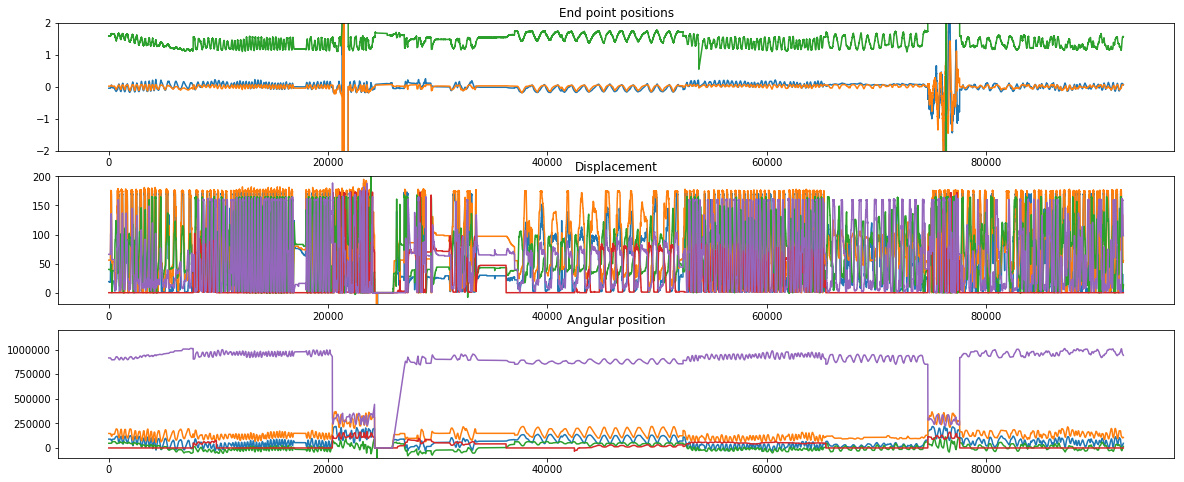

In [4]:

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(3,1,1)
#_, axes = plt.subplots(3,1,figsize=(20,8))

ax1.plot(X_pose)
ax1.set_ylim([-2,2])
ax1.set_title("End point positions")

ax2 = fig.add_subplot(3,1,2)
ax2.plot(X_disp)
ax2.set_ylim([-20,200])
ax2.set_title("Displacement")

ax3 = fig.add_subplot(3,1,3)
ax3.plot(X_ang)
ax3.set_ylim([-100000,1200000])
ax3.set_title("Angular position")
plt.show()
fig.savefig('data')

In [15]:
# removing outliers
for i in range(3):
    X_pose = X_pose[X_pose[:,i] < 2,:]
    X_pose= X_pose[X_pose[:,i] > -2,:]

for i in range(5):
    X_disp = X_disp[X_disp[:,i] < 200,:]
    X_disp= X_disp[X_disp[:,i] > -20,:]
    
for i in range(5):
    X_ang = X_ang[X_ang[:,i] < 1200000,:]
    X_ang= X_ang[X_ang[:,i] > -10000,:]

    
# conversion to tensors    
x = np.array(X_ang)
y = np.array(X_pose)
x  = torch.from_numpy(x)
y = torch.from_numpy(y)

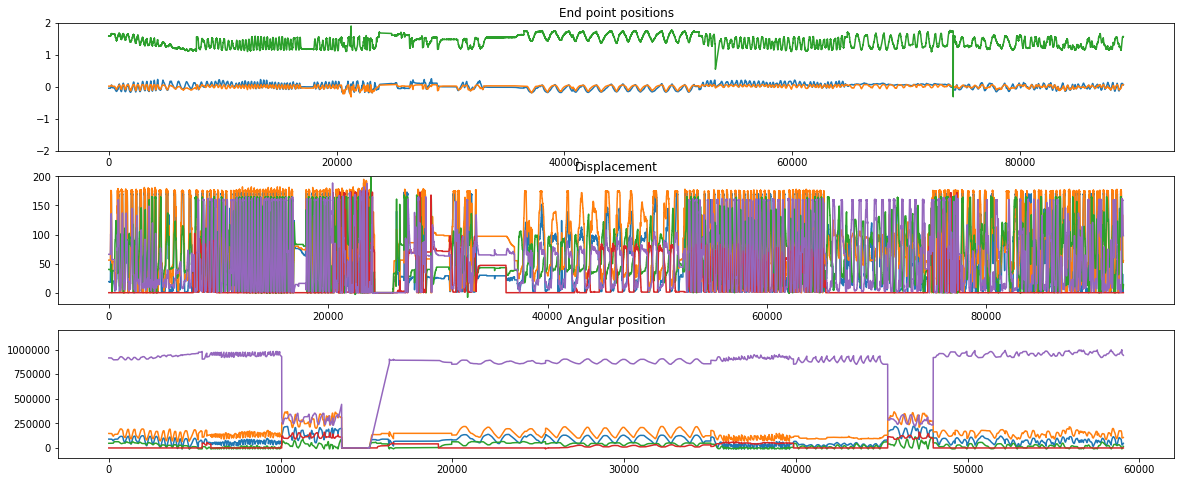

In [12]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(3,1,1)
#_, axes = plt.subplots(3,1,figsize=(20,8))

ax1.plot(X_pose)
ax1.set_ylim([-2,2])
ax1.set_title("End point positions")

ax2 = fig.add_subplot(3,1,2)
ax2.plot(X_disp)
ax2.set_ylim([-20,200])
ax2.set_title("Displacement")

ax3 = fig.add_subplot(3,1,3)
ax3.plot(X_ang)
ax3.set_ylim([-100000,1200000])
ax3.set_title("Angular position")
plt.show()
fig.savefig('data_clean')

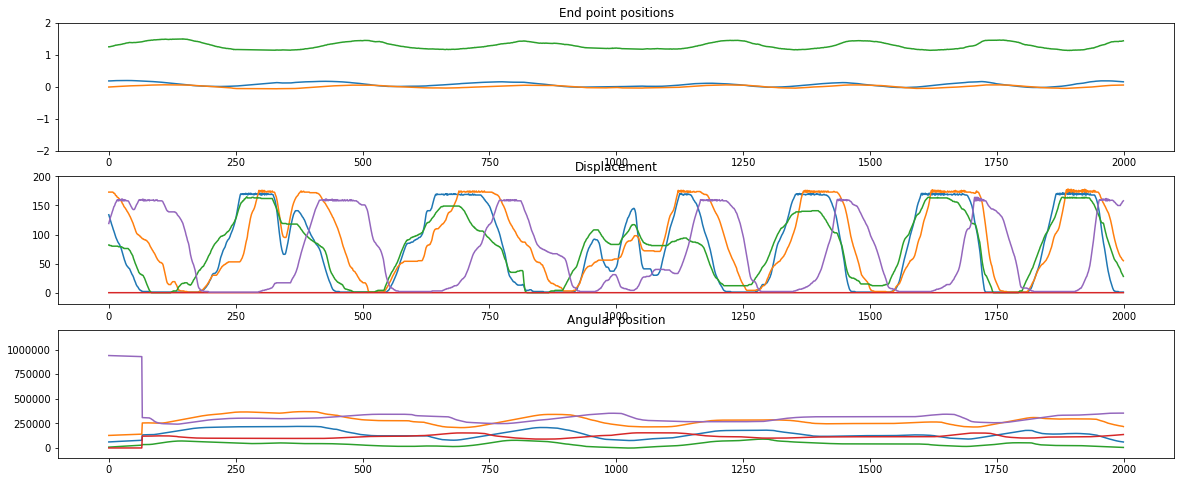

In [14]:
# plotting after removing outliers

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(3,1,1)
#_, axes = plt.subplots(3,1,figsize=(20,8))

ax1.plot(X_pose[10000:12000,:])
ax1.set_ylim([-2,2])
ax1.set_title("End point positions")

ax2 = fig.add_subplot(3,1,2)
ax2.plot(X_disp[10000:12000,:])
ax2.set_ylim([-20,200])
ax2.set_title("Displacement")

ax3 = fig.add_subplot(3,1,3)
ax3.plot(X_ang[10000:12000,:])
ax3.set_ylim([-100000,1200000])
ax3.set_title("Angular position")
plt.show()
fig.savefig('try')

In [68]:
print(len(X_pose))

89056


In [63]:
# Generative Adversarial Networks (GAN) example in PyTorch.
# See related blog post at https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f#.sch4xgsa9
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import random

# Data params
data_mean = 4
data_stddev = 1.25

# Model params
g_input_size = 500     # Random noise dimension coming into generator, per output vector
g_hidden_size = 1000   # Generator complexity
g_output_size = 500    # size of generated output vector
d_input_size = 500   # Minibatch size - cardinality of distributions
d_hidden_size = 1000   # Discriminator complexity
d_output_size = 1    # Single dimension for 'real' vs. 'fake'
minibatch_size = 128

d_learning_rate = 2e-3  # 2e-4
g_learning_rate = 2e-3
optim_betas = (0.9, 0.999)
num_epochs = 100000
print_interval = 200
d_steps = 1  # 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
g_steps = 1

# ### Uncomment only one of these
(name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
#(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)

print("Using data [%s]" % (name))

# ##### DATA: Target data and generator input data

def get_distribution_sampler(mu, sigma):
    return lambda m, n: torch.Tensor(np.random.normal(mu, sigma, (m, n)))  # Gaussian

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian

# ##### MODELS: Generator model and discriminator model

class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.LeakyReLU(0.2)
        self.map3 = nn.Linear(hidden_size, hidden_size)
        self.map4 = nn.LeakyReLU(0.2)
        self.map5 = nn.Linear(hidden_size, hidden_size)
        self.map6 = nn.LeakyReLU(0.2)
        self.map7 = nn.Linear(hidden_size, output_size)
        self.map8 = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.map1(x)
        x = self.map2(x)
        x = self.map3(x)
        x = self.map4(x)
        x = self.map5(x)
        x = self.map6(x)
        x = self.map7(x)
        x = self.map8(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.LeakyReLU(0.2)
        self.map3 = nn.Linear(hidden_size, hidden_size)
        self.map4 = nn.BatchNorm1d(hidden_size)
        self.map5 = nn.LeakyReLU(0.2)
        self.map6 = nn.Linear(hidden_size, output_size)

        
    def forward(self, x):
        x = self.map1(x)
        x = self.map2(x)
        x = self.map3(x)
        x = self.map4(x)
        x = self.map5(x)
        x = self.map6(x)
        return F.sigmoid(x)

def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

def decorate_with_diffs(data, exponent):
    mean = torch.mean(data.data, 1, keepdim=True)    
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    return torch.cat([data, diffs], 1)   #

# .t() returns the same variable but with transposed data

d_sampler = get_distribution_sampler(data_mean, data_stddev)
gi_sampler = get_generator_input_sampler()
G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = Discriminator(input_size=d_input_func(d_input_size), hidden_size=d_hidden_size, output_size=d_output_size)
criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
#criterion = nn.MSELoss()
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=optim_betas)
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=optim_betas)

mus_d = torch.zeros(num_epochs,5)
stds_d = torch.zeros(num_epochs,5)
mus_g = torch.zeros(num_epochs,5)
stds_g = torch.zeros(num_epochs,5)


for epoch in range(num_epochs):
    for d_index in range(d_steps):
        # 1. Train D on real+fake
        D.zero_grad()

        #  1A: Train D on real
        #d_real_data = Variable(d_sampler(d_input_size)) # 100 points Variable
        #start  = random.sample(range(0, len(X_ang)-101), 1)[0]
        #end = start + 100        
        #d_real_data = x[start:end,:]
        
        start  = random.sample(range(0, len(X_ang)-101),minibatch_size)
        end = torch.ones(minibatch_size).type(torch.IntTensor) 
        d_real_data = Variable(torch.ones(minibatch_size,100,5))
        for i in range(minibatch_size):
            end[i] =  start[i] + 100
            d_real_data.data[i,:,:] = x[start[i]:end[i],:]
        
        data_mean_d = torch.mean(d_real_data.data,0)
        mus_d[epoch,:] = torch.mean(data_mean_d,0)
        stds_d[epoch,:] = torch.std(data_mean_d,0)
        
        d_real_data =  Variable(d_real_data.data.resize_((minibatch_size,500))) #10x500 points
        d_real_data  = d_real_data.type(torch.FloatTensor)
        d_real_decision = D(preprocess(d_real_data))  # 1 point Variable
        d_real_error = criterion(d_real_decision, Variable(torch.ones(minibatch_size)))  # ones = true
        d_real_error.backward() # compute/store gradients, but don't change params

        #  1B: Train D on fake
        d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size)) #100 points variable
        d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels. #100x5 points
        #d_fake_data.data =  d_fake_data.data.resize_((1,500)) #500 points
        d_fake_decision = D(preprocess(d_fake_data))   # 1 point
        d_fake_error = criterion(d_fake_decision, Variable(torch.zeros(minibatch_size)))  # zeros = fake
        d_fake_error.backward()
        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

    for g_index in range(g_steps):
        # 2. Train G on D's response (but DO NOT train D on these labels)
        G.zero_grad()

        gen_input = Variable(gi_sampler(minibatch_size, g_input_size))  #10x500 points
        g_fake_data = G(gen_input)   # 10 x 500 points
        
        #g_fake_data.data = g_fake_data.data.resize_((1,500))
        g_fake_data  = g_fake_data.type(torch.FloatTensor)
        
        dg_fake_decision = D(preprocess(g_fake_data))  # 1 point
        g_error = criterion(dg_fake_decision, Variable(torch.ones(minibatch_size)))  # we want to fool, so pretend it's all genuine
        
        #print(g_error)
        g_error.backward()
        g_optimizer.step()  # Only optimizes G's parameters
        
        data_mean_g = torch.mean(g_fake_data.data.resize_((minibatch_size,100,5)),0)
        mus_g[epoch,:] = torch.mean(data_mean_g,0)
        stds_g[epoch,:] = torch.std(data_mean_g,0)
    
    if epoch % print_interval == 0:
        print("%s: D: %s/%s G: %s (Real: %s, Fake: %s) " % (epoch,
                                                            extract(d_real_error)[0],
                                                            extract(d_fake_error)[0],
                                                            extract(g_error)[0],
                                                            stats(extract(d_real_data)),
                                                            stats(extract(d_fake_data))))



Using data [Raw data]


/home/pranshulsaini/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


0: D: 0.6979137063026428/0.6960970163345337 G: 0.6676779389381409 (Real: [218758.38526303589, 323600.37268735416], Fake: [0.009916412010405648, 0.019288396132615362]) 
200: D: 0.09914155304431915/0.21455374360084534 G: 2.2875943183898926 (Real: [218680.71514258086, 325972.2476964214], Fake: [52.878246230515508, 308.64728577898796]) 
400: D: 0.26743459701538086/0.258298397064209 G: 2.691786766052246 (Real: [218428.33087329214, 321486.24107576511], Fake: [318.52453054074419, 678.73701012554409]) 
600: D: 0.20149236917495728/0.22328393161296844 G: 3.0777714252471924 (Real: [218842.82712569536, 330343.21565077914], Fake: [845.91422936227536, 1565.4920213641951]) 
800: D: 0.16475029289722443/0.23525674641132355 G: 3.4889254570007324 (Real: [210693.0005864916, 317153.13571085758], Fake: [2063.9334124794, 3333.2900891071517]) 
1000: D: 0.09388367831707001/0.1211622953414917 G: 3.208123207092285 (Real: [216734.83354004688, 321221.86928074888], Fake: [2217.7269218618676, 2901.8779304601217]) 
1

9800: D: 0.10013735294342041/0.030487949028611183 G: 3.8272290229797363 (Real: [220978.06337609302, 326762.58491953585], Fake: [152644.36495617754, 226987.89842640352]) 
10000: D: 0.025081349536776543/0.029610656201839447 G: 6.064578056335449 (Real: [222289.06297583415, 329357.37292572326], Fake: [141109.19240139594, 211325.88452289131]) 
10200: D: 0.12844370305538177/0.08431146293878555 G: 4.704779624938965 (Real: [218958.13502043029, 318684.65817569621], Fake: [109480.42538378238, 165029.78232567347]) 
10400: D: 0.08834263682365417/0.215762659907341 G: 5.688323497772217 (Real: [215804.21410521827, 323840.78989979142], Fake: [113682.82494881825, 175461.52788781034]) 
10600: D: 0.11494626104831696/0.0010940615320578218 G: 10.99260139465332 (Real: [223222.67475398639, 329156.38677005214], Fake: [27584.400718674682, 129906.87709920513]) 
10800: D: 0.009317254647612572/0.016171693801879883 G: 9.707049369812012 (Real: [216531.56804852761, 323534.9683818685], Fake: [120790.55853251967, 1932

19600: D: 0.41676658391952515/0.05282403156161308 G: 3.864330768585205 (Real: [217065.67469406035, 327339.07815185876], Fake: [94119.562820887237, 155561.07991738195]) 
19800: D: 0.07817556709051132/0.3248215317726135 G: 3.7765254974365234 (Real: [212612.14858868651, 319934.09296740673], Fake: [125994.4814021037, 176965.1132244741]) 
20000: D: 0.6989428400993347/0.6487348079681396 G: 2.4089460372924805 (Real: [222178.95809104654, 327475.99301260913], Fake: [113508.57049562834, 167978.89507395207]) 
20200: D: 0.15140700340270996/0.26614442467689514 G: 4.038420677185059 (Real: [209982.26017220772, 318305.00470221351], Fake: [88384.775770682318, 142346.09586310669]) 
20400: D: 0.5841814279556274/0.006785426288843155 G: 6.508095741271973 (Real: [223049.16627099758, 327221.96379638038], Fake: [181809.06029198534, 259279.73573390636]) 
20600: D: 0.8046948313713074/0.03471054509282112 G: 6.976852893829346 (Real: [219296.44033318269, 329609.27853577066], Fake: [100981.75498171916, 154711.56755

29400: D: 0.048820845782756805/0.23900079727172852 G: 4.216139793395996 (Real: [218294.59765668304, 324054.60134477197], Fake: [202928.55412676549, 307653.3600069728]) 
29600: D: 0.10248655080795288/0.37082362174987793 G: 3.2572555541992188 (Real: [218564.96618300804, 325140.00467504078], Fake: [229409.00784554295, 346695.85187344608]) 
29800: D: 0.2173650711774826/0.0411025807261467 G: 7.544026851654053 (Real: [217936.42469502767, 323754.99183240673], Fake: [190671.53647637874, 263708.53293016867]) 
30000: D: 0.20837333798408508/0.2253781110048294 G: 2.811476707458496 (Real: [222627.43200030571, 328210.13611969328], Fake: [187019.90122844532, 284341.61551704863]) 
30200: D: 0.18493668735027313/0.054025862365961075 G: 3.0310420989990234 (Real: [215692.87022629994, 321403.30941564031], Fake: [182433.70522510807, 271160.93755074713]) 
30400: D: 0.5917209386825562/0.17408105731010437 G: 2.5660436153411865 (Real: [223861.93978699986, 333597.08446906204], Fake: [203638.75105071469, 292505.9

39200: D: 0.3139900863170624/0.10651375353336334 G: 3.654780626296997 (Real: [220455.59320243917, 327650.06903393439], Fake: [309487.91083490272, 472572.03070392244]) 
39400: D: 0.5563777089118958/0.39625251293182373 G: 3.294055938720703 (Real: [212451.85711006474, 330133.44718626403], Fake: [358960.47891303123, 510578.68091981573]) 
39600: D: 0.18167787790298462/0.4249602258205414 G: 4.046562194824219 (Real: [220749.8336871927, 325890.6948393581], Fake: [257364.55356113106, 381297.37926483795]) 
39800: D: 0.09771090745925903/0.08866550773382187 G: 2.8826889991760254 (Real: [219253.61486321516, 323078.93211544957], Fake: [269266.44540180353, 406994.21217526309]) 
40000: D: 0.2790980339050293/0.19834087789058685 G: 7.2766218185424805 (Real: [219122.04546626474, 328061.62052588159], Fake: [215007.72223170742, 318667.36489971325]) 
40200: D: 0.13839371502399445/0.03763196989893913 G: 2.7892792224884033 (Real: [219545.98288067669, 325626.843868036], Fake: [269351.23052763904, 421630.283932

49000: D: 0.3753304183483124/0.10750528424978256 G: 2.6963107585906982 (Real: [218597.17796622191, 318858.25888659852], Fake: [436332.73566650652, 650338.30438712961]) 
49200: D: 0.2612801492214203/0.02440907433629036 G: 6.556702613830566 (Real: [218902.25708319919, 322172.96535423351], Fake: [488920.17358570191, 713030.3243637986]) 
49400: D: 0.16141723096370697/0.5994216799736023 G: 3.925943613052368 (Real: [213409.74434648539, 317443.47645241086], Fake: [424862.83735194156, 629362.23020036751]) 
49600: D: 0.14246192574501038/0.6336878538131714 G: 2.7854340076446533 (Real: [218615.57755172357, 321242.67681753362], Fake: [367975.51089452161, 555975.58943875076]) 
49800: D: 0.1682031899690628/0.18600183725357056 G: 2.060136318206787 (Real: [217189.25224341784, 319679.77227594506], Fake: [446907.40295795753, 659991.23668352212]) 
50000: D: 0.12861333787441254/0.21474377810955048 G: 4.3409318923950195 (Real: [216548.3971571337, 322654.20403749164], Fake: [404540.0165423482, 610234.604150

58800: D: 0.14118865132331848/0.055634789168834686 G: 6.51359224319458 (Real: [216152.11215217109, 321552.65403622319], Fake: [460878.78347888333, 680439.9899524505]) 
59000: D: 0.12534043192863464/0.2800161838531494 G: 1.7155429124832153 (Real: [216013.64605504714, 325922.13545958744], Fake: [381859.38745671074, 589638.10952285153]) 
59200: D: 0.223175048828125/0.47356700897216797 G: 2.992454767227173 (Real: [220886.78680092937, 327924.20254668657], Fake: [422801.17218078981, 624096.83768270735]) 
59400: D: 0.11661925911903381/0.1631699502468109 G: 3.0636117458343506 (Real: [217869.58581332263, 323334.20714920911], Fake: [467508.09746437299, 708174.00413996936]) 
59600: D: 0.20266149938106537/0.4123377799987793 G: 4.153142929077148 (Real: [218637.63089427122, 318683.82963645918], Fake: [461639.72380408744, 673871.41000933945]) 
59800: D: 0.10142622143030167/0.16712650656700134 G: 2.747448444366455 (Real: [214523.70953466761, 318368.08887946047], Fake: [521437.81279392005, 757788.64675

68600: D: 0.0038313311524689198/0.0055673569440841675 G: 13.70480728149414 (Real: [221143.80217250055, 330221.13725142065], Fake: [303739.18933464622, 719331.00357654586]) 
68800: D: 0.0020032247994095087/0.02266697771847248 G: 14.019495964050293 (Real: [220898.4161276329, 321988.22388304345], Fake: [115564.5505607388, 565655.2966509969]) 
69000: D: 0.0027044008020311594/0.0052861724980175495 G: 13.681751251220703 (Real: [216105.76836316322, 324753.85452857829], Fake: [150547.58908057879, 671918.57852505194]) 
69200: D: 0.07247186452150345/0.0008056045044213533 G: 15.509603500366211 (Real: [216996.86941387138, 313794.19104179135], Fake: [91375.387204026221, 638995.09949169273]) 
69400: D: 0.004168530460447073/0.0020910499151796103 G: 13.847723007202148 (Real: [212592.80347836547, 320326.0548091277], Fake: [162716.84831012911, 681704.43991141813]) 
69600: D: 0.00027794536435976624/0.06600255519151688 G: 15.621664047241211 (Real: [221358.88868893858, 324368.22278451378], Fake: [66885.013

KeyboardInterrupt: 

In [9]:
print(d_real_data.data.shape) 

torch.Size([1, 500])


Text(0.5,1,'standard deviation')

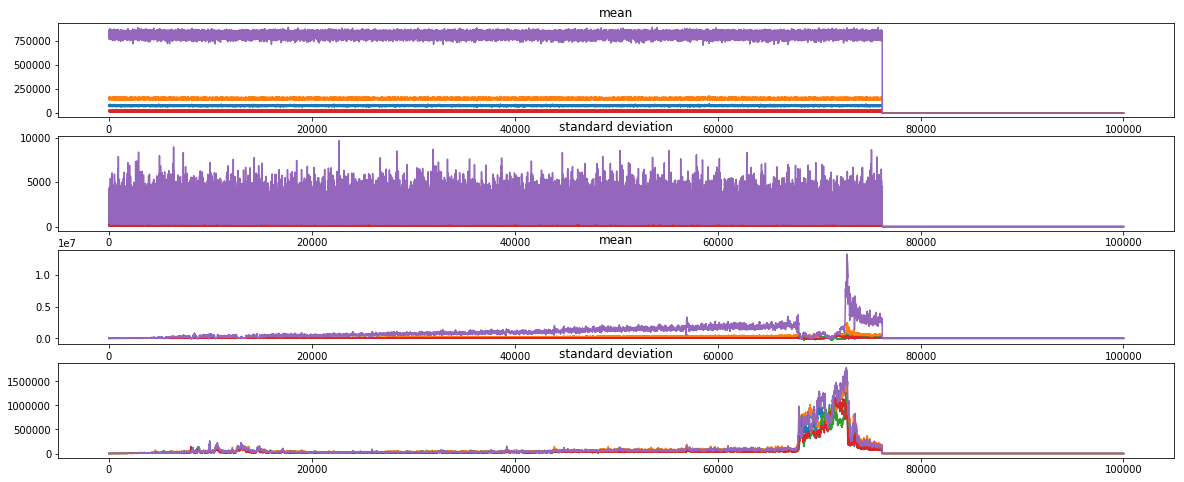

In [64]:
#plotting the output of generator function

fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(4,1,1)
ax1.plot(mus_d.numpy())
#ax1.set_ylim([-2,2])
ax1.set_title("mean")

ax2 = fig.add_subplot(4,1,2)
ax2.plot(stds_d.numpy())
#ax2.set_ylim([-20,200])
ax2.set_title("standard deviation")

ax3= fig.add_subplot(4,1,3)
ax3.plot(mus_g.numpy())
#ax1.set_ylim([-2,2])
ax3.set_title("mean")

ax4 = fig.add_subplot(4,1,4)
ax4.plot(stds_g.numpy())
#ax2.set_ylim([-20,200])
ax4.set_title("standard deviation")

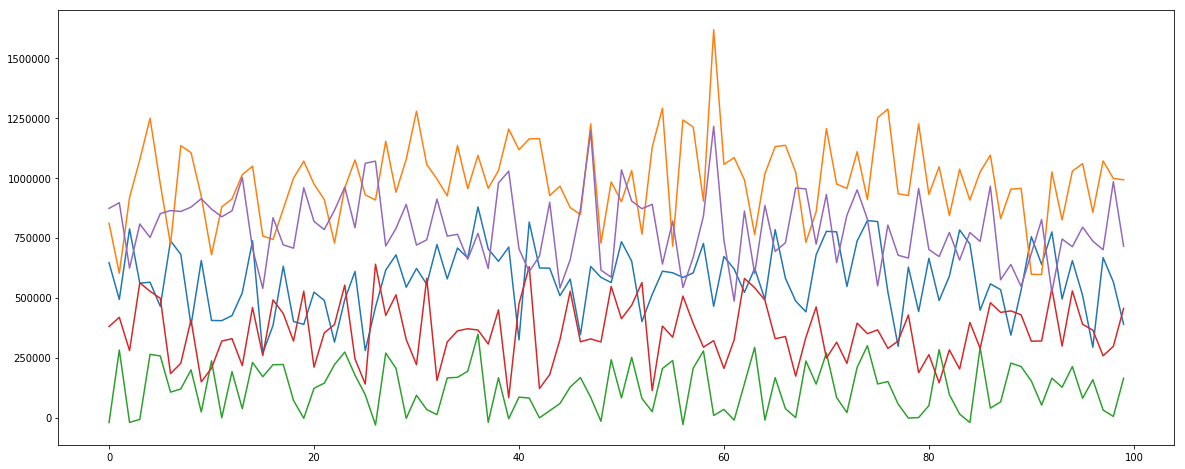

In [65]:
inp = Variable(gi_sampler(minibatch_size, g_input_size))
result = G(inp)
data = torch.mean(result.data,0)
data = result.data.resize_((100,5))
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(data.numpy())
plt.show()
fig.savefig('generated_disp_data')


In [96]:
b = get_distribution_sampler(0, 1)
val = b(10)
print(val.shape)
g = val.numpy()
print(g)
d = val[0,2:4]
print(d)


torch.Size([1, 10])
[[ 1.15387475 -0.38288826 -0.76640564 -0.92195743  1.80269527 -0.06954619
  -1.60150361  1.16960931  0.43478948  0.28135628]]

-0.7664
-0.9220
[torch.FloatTensor of size 2]



In [14]:
a= torch.rand(5,2)
b = a.resize_((1,10))
c = Variable(b)
print(c)

Variable containing:
 0.6362  0.7390  0.6751  0.8641  0.2280  0.0448  0.6161  0.9324  0.0697  0.9402
[torch.FloatTensor of size 1x10]



In [8]:
def get_distribution_sampler(mu, sigma):
    return lambda m, n: torch.Tensor(np.random.normal(mu, sigma, (m, n)))  # Gaussian

def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)  # Uniform-dist data into generator, _NOT_ Gaussian

In [14]:
gen = get_distribution_sampler(0,1)
values = gen(5,3)
print(values)
#print(torch.mean(values,1))


 0.2010 -0.9473  0.6060
 0.0806 -1.7922 -1.4095
 0.2822  0.5589 -0.2140
-0.1300 -0.3110  0.4039
-0.8335  0.2413 -0.7894
[torch.FloatTensor of size 5x3]



In [41]:
import random
start  = random.sample(range(0, len(X_ang)-101), 10)
end = torch.ones(10).type(torch.IntTensor) 
data = torch.ones(10,100,5)
for i in range(10):
    end[i] =  start[i] + 100
    data[i,:,:] = x[start[i]:end[i],:]

m = torch.mean(data,0)
n = torch.mean(m,0)
print(n)


1.00000e+05 *
  0.5562
  1.2523
  0.1330
  0.1166
  9.1613
[torch.FloatTensor of size 5]




( 0 ,.,.) = 
  1.0304e+05  2.6209e+05  1.3257e+04  1.2254e+05  3.5038e+05
  1.0044e+05  2.6012e+05  1.3079e+04  1.2295e+05  3.5079e+05
  9.9320e+04  2.5736e+05  1.2871e+04  1.2333e+05  3.5116e+05
                             ⋮                              
  5.2459e+04  2.0074e+05 -4.0234e+03  1.4879e+05  3.4160e+05
  5.2478e+04  2.0071e+05 -4.0778e+03  1.4884e+05  3.4138e+05
  5.2501e+04  2.0068e+05 -4.1820e+03  1.4887e+05  3.4118e+05

( 1 ,.,.) = 
  1.2894e+05  1.9415e+05  4.7746e+04  0.0000e+00  8.8304e+05
  1.2886e+05  1.9409e+05  4.7746e+04  0.0000e+00  8.8304e+05
  1.2877e+05  1.9405e+05  4.7746e+04  0.0000e+00  8.8304e+05
                             ⋮                              
  1.1555e+05  1.7766e+05  5.0234e+04  0.0000e+00  8.8111e+05
  1.1542e+05  1.7751e+05  5.0258e+04  0.0000e+00  8.8103e+05
  1.1532e+05  1.7733e+05  5.0297e+04  0.0000e+00  8.8093e+05

( 2 ,.,.) = 
  7.7742e+04  1.7110e+05 -4.0380e+03  0.0000e+00  9.8899e+05
  7.7742e+04  1.7110e+05 -4.0380e+03  0.000